<a href="https://colab.research.google.com/github/Murolando/windows_segment_nn/blob/main/segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Обучение нейронной сети для задачи сегментации окон

Описание датасета:

Датасет собирался тремя способами,  через парсер из Яндекс картинок, с помощью ручек и с помощью наших друзей



---


Датасет размечался также вручную с помощью веб - приложения [https://www.makesense.ai/] 


---

Всего у нас вышло более 200 изображений, однако подходящих из них оказалось только 86



---



1.   Картинки с названием 1.jpg - Исходное фото
2.   Картинки с названием 2.jpg - Фото с маской



## Подготовительный этап

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 419 kB 14.6 MB/s 


In [ ]:
import torch 
from torch.utils.data import DataLoader
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from torchvision.utils import save_image

# Для считывания картинок
from skimage.io import imread
import os
from PIL import Image
import io

from skimage.transform import resize

# Для вывода картинок 
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Метрики 
from torchmetrics import JaccardIndex

### Подгрузим картиночки

In [ ]:
# подгружаем картинки
images = []
masks = []
root = '/content/drive/MyDrive/Datashkola2/windows segment ez/jsons/pairs'

for root, dirs,files in os.walk('/content/drive/MyDrive/Datashkola2/windows segment ez/jsons/pairs'):
  for dir in dirs:
    images.append(imread(os.path.join(root,dir, '2.jpg')))
    masks.append(imread(os.path.join(root,dir, '1.jpg')))


In [ ]:
images[0].shape

(960, 1280, 3)

In [ ]:
masks[0].shape

(960, 1280)

### Уменьшаем разрешение картинок, нормализуем их и переводим в np array



In [ ]:
# Уменьшаем разрешение картинок, нормализуем их и переводим в np array
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in masks]


In [ ]:
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 86 images


In [ ]:
X[0].shape

(256, 256, 3)

In [ ]:
Y[0].shape

(256, 256)

### Взглянем на результат

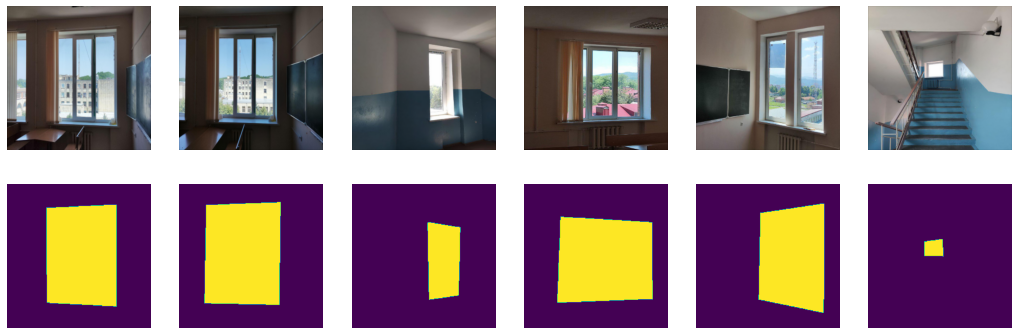

In [ ]:
# результаты
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

###Мы решили поделить выборку на 2 части по 60, 26 фотографий, для обучения и теста соответственно.

Но т.к фотографий очень мало мы будем заниматься аугментацией, и молиться что этого хватит

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, ts = np.split(ix, [60])

In [ ]:
print(len(tr), len(ts))

60 26


### Сделаем пары для обучения и тестирования модели 

In [ ]:
batch_size = 7
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=1, shuffle=True)

In [ ]:
len(data_tr)

9

### Переход на gpu

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Метрика

In [ ]:
# метрика
jaccard = JaccardIndex(num_classes=2).to(device)

### Loss

In [ ]:
def dice_loss(y_true, y_pred):
    smooth = 1.0
    y_pred = torch.sigmoid(y_pred)
    y_pred = y_pred[:, 0].contiguous().view(-1)
    y_true = y_true[:, 0].contiguous().view(-1)
    intersection = (y_pred * y_true).sum()
    dsc = (2. * intersection + smooth) / (
        y_pred.sum() + y_true.sum() + smooth
    )
    return 1. - dsc

In [ ]:
def bce_loss(y_real, y_pred):
    y_pred = torch.sigmoid(y_pred)
    return torch.mean(y_pred - torch.mul(y_pred, y_real) + torch.log(1 + torch.exp(-y_pred)))

In [ ]:
import math
def dice_bce_loss(y_true, y_pred):
    dice = dice_loss(y_true, y_pred)
    bce = bce_loss(y_true, y_pred)
    return bce - math.log(dice)

## Реализация модели

### Модель Unet

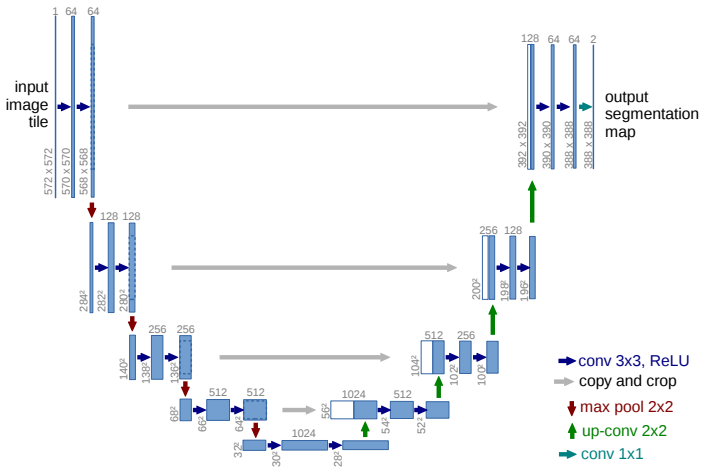

In [ ]:
class UNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.enc0 = nn.Sequential(
      nn.Conv2d(3,64,3, padding = 1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64,64,3, padding = 1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
    )

    self.pool = nn.MaxPool2d(kernel_size = 2, stride=2, padding=0)

    self.enc1 = nn.Sequential(
      nn.Conv2d(64,128,3, padding = 1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Conv2d(128,128,3, padding = 1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
    )


    self.enc2 = nn.Sequential(
      nn.Conv2d(128,256,3, padding = 1),
      nn.BatchNorm2d(256),
      nn.ReLU(),
      nn.Conv2d(256,256,3, padding = 1),
      nn.BatchNorm2d(256),
      nn.ReLU(),
    )
    

    self.enc3 = nn.Sequential(
      nn.Conv2d(256,512,3, padding = 1),
      nn.BatchNorm2d(512),
      nn.ReLU(),
      nn.Conv2d(512,512,3, padding = 1),
      nn.BatchNorm2d(512),
      nn.ReLU(),
    )


    self.enc4 = nn.Sequential(
      nn.Conv2d(512,1024,3, padding = 1),
      nn.BatchNorm2d(1024),
      nn.ReLU(),
      nn.Conv2d(1024,1024,3, padding = 1),
      nn.BatchNorm2d(1024),
      nn.ReLU(),
    )

    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True) 

    self.dec0 = nn.Sequential(
      nn.Conv2d(512+1024,512,3, padding = 1),
      nn.BatchNorm2d(512),
      nn.ReLU(),
      nn.Conv2d(512,512,3, padding = 1),
      nn.BatchNorm2d(512),
      nn.ReLU(),
    )
 

    self.dec1 = nn.Sequential(
      nn.Conv2d(512+256,256,3, padding = 1),
      nn.BatchNorm2d(256),
      nn.ReLU(),
      nn.Conv2d(256,256,3, padding = 1),
      nn.BatchNorm2d(256),
      nn.ReLU(),
    )
   

    self.dec2 = nn.Sequential(
      nn.Conv2d(128+256,128,3, padding = 1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Conv2d(128,128,3, padding = 1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
    )


    self.dec4 = nn.Sequential(
      nn.Conv2d(128+64,64,3, padding = 1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64,64,3, padding = 1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
    )

    self.dec5 = nn.Sequential(
      nn.Conv2d(64,1,3, padding = 1),
    )


  def forward(self, x):
   
    conv1 = self.enc0(x)
    x = self.pool(conv1)

    conv2 = self.enc1(x)
    x = self.pool(conv2)

    conv3 = self.enc2(x)
    x = self.pool(conv3)
    
    conv4 = self.enc3(x)
    x = self.pool(conv4)

    x = self.enc4(x)
   
    x = self.upsample(x) 

    # print(x.shape)
    x = torch.cat([x, conv4], dim=1)
    # print(x.shape,conv4.shape)
    x = self.dec0(x)
    # print(x.shape)

    x = self.upsample(x) 
    x = torch.cat([x, conv3], dim=1)
    x = self.dec1(x)

    x = self.upsample(x) 
    x = torch.cat([x, conv2], dim=1)
    x = self.dec2(x)

    x = self.upsample(x) 
    x = torch.cat([x, conv1], dim=1)
    x = self.dec4(x)

    x = self.dec5(x)

    return  x


### Обучение Unet

In [ ]:
def train_unet(model,loss_fn, opt, epochs, data_tr):
  
    for epoch in range(epochs):
      oleg = 10000
      score = 10000
      for X_batch, Y_batch in data_tr:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        # X = X_batch[0]
        # print(X.shape)
        opt.zero_grad()
        # print(type(X))
        preds = model.forward(X_batch) 
        # preds = torch.tensor(preds)
        # print(preds.shape,Y_batch.shape)
        loss_value = loss_fn(Y_batch, preds)
        oleg = loss_value
        loss_value.backward()
        # score = iou_pytorch(preds,Y_batch)
        score = jaccard(preds,Y_batch.to(torch.int32))
        # print(1)
        opt.step()

      # score = iou_pytorch(val_pred,Y_val)
      # Y_val.type(torch.int64)
      print(epoch, oleg, score)
    
      

#### Ошибка BCE

In [ ]:
unet_bce = UNet().to(device)
optimizer = torch.optim.Adam(unet_bce.parameters(), lr=0.0001)
train_unet(unet_bce,bce_loss, optimizer, 20,data_tr)

0 tensor(0.7439, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.6936, device='cuda:0')
1 tensor(0.7528, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.6325, device='cuda:0')
2 tensor(0.6620, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.7598, device='cuda:0')
3 tensor(0.6755, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.6930, device='cuda:0')
4 tensor(0.6254, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.6192, device='cuda:0')
5 tensor(0.6175, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.8144, device='cuda:0')
6 tensor(0.5624, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.8218, device='cuda:0')
7 tensor(0.5743, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.6161, device='cuda:0')
8 tensor(0.5826, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.8517, device='cuda:0')
9 tensor(0.6071, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.7799, device='cuda:0')
10 tensor(0.5783, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.8818, device='cuda:0'

In [ ]:
# unet_bce = torch.load('/content/drive/MyDrive/Datashkola2/windows segment ez/unet_bce.pt')

#### Ошбика BCE - Ln(Dice)

In [ ]:
unet_bce_dice = UNet().to(device)
optimizer = torch.optim.Adam(unet_bce_dice.parameters(), lr=0.0001)
train_unet(unet_bce_dice,dice_bce_loss, optimizer, 20, data_tr)

0 tensor(1.6123, device='cuda:0', grad_fn=<SubBackward0>) tensor(0.5245, device='cuda:0')
1 tensor(1.9399, device='cuda:0', grad_fn=<SubBackward0>) tensor(0.7470, device='cuda:0')
2 tensor(1.9409, device='cuda:0', grad_fn=<SubBackward0>) tensor(0.6974, device='cuda:0')
3 tensor(2.0741, device='cuda:0', grad_fn=<SubBackward0>) tensor(0.8000, device='cuda:0')
4 tensor(2.1263, device='cuda:0', grad_fn=<SubBackward0>) tensor(0.7412, device='cuda:0')
5 tensor(2.3709, device='cuda:0', grad_fn=<SubBackward0>) tensor(0.8357, device='cuda:0')
6 tensor(2.1162, device='cuda:0', grad_fn=<SubBackward0>) tensor(0.7095, device='cuda:0')
7 tensor(2.5274, device='cuda:0', grad_fn=<SubBackward0>) tensor(0.8338, device='cuda:0')
8 tensor(2.5594, device='cuda:0', grad_fn=<SubBackward0>) tensor(0.8941, device='cuda:0')
9 tensor(2.6305, device='cuda:0', grad_fn=<SubBackward0>) tensor(0.8596, device='cuda:0')
10 tensor(2.4361, device='cuda:0', grad_fn=<SubBackward0>) tensor(0.7968, device='cuda:0')
11 tensor

In [ ]:
# unet_bce_dice = torch.load('/content/drive/MyDrive/Datashkola2/windows segment ez/unet_bce_dice.pt')

### Предсказания Unet

In [ ]:
def predictor(model, data_ts):
  score = 0
  X_hat = 0
  Y_hat = 0
  for X, Y in data_ts:
    X , Y = X.to(device),Y.to(device)
    # print(X.shape,Y.shape)
    Y_pred = model.forward(X)
    X_hat = X.to('cpu')
    Y_hat = Y_pred.detach().to('cpu')
    score+= jaccard(Y_pred,Y.to(torch.int32))
  
  # вывод на экран результатов
  plt.figure(figsize=(13, 10))
  plt.subplot(2, 2, 1) 
  X_hat = X_hat.squeeze(0)
  # print(type(X_hat),X_hat)
  plt.imshow(np.rollaxis(X_hat.numpy(), 0, 3), cmap='gray')
  plt.title('Real')
  plt.axis('off')


  plt.subplot(2, 2, 2) 
  #print(type(X_hat))
  Y_hat = Y_hat.squeeze(0)
  # print(Y_hat.detach().numpy())
  plt.imshow(Y_hat.numpy()[0])
  plt.title('Output')
  plt.axis('off')
  plt.show()
  return score/len(data_ts)

#### BCE

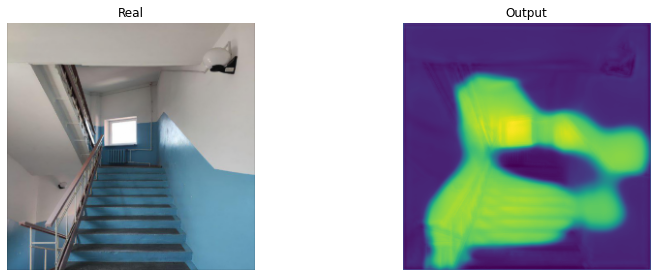

tensor(0.6989, device='cuda:0')

In [ ]:
predictor(unet_bce,data_ts)

In [ ]:
# torch.save(unet_bce,'/content/drive/MyDrive/Datashkola2/windows segment ez/unet_bce.pt')

#### BCE - Ln(Dice)

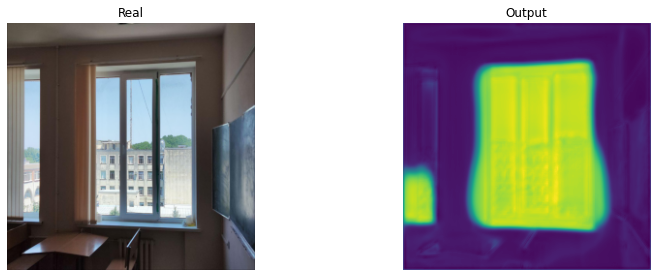

tensor(0.7136, device='cuda:0')

In [ ]:
predictor(unet_bce_dice,data_ts)

In [ ]:
# torch.save(unet_bce_dice,'/content/drive/MyDrive/Datashkola2/windows segment ez/unet_bce_dice.pt')

## Результаты

### Пути улучшения работы модели:
  

1.   Использовать кодировщик из уже обученной модели 
2.   Использовать Feature Pyramid Network
3.   Использовать аугментацию



## P.S Деплой на сервер

### Новая обрезанная модель

In [ ]:
class UNet1(nn.Module):
  def __init__(self):
    super().__init__()

    self.enc0 = nn.Sequential(
      nn.Conv2d(3,64,3, padding = 1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      # nn.Conv2d(64,64,3, padding = 1),
      # nn.BatchNorm2d(64),
      # nn.ReLU(),
    )

    self.pool = nn.MaxPool2d(kernel_size = 2, stride=2, padding=0)

    self.enc1 = nn.Sequential(
      nn.Conv2d(64,128,3, padding = 1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      # nn.Conv2d(128,128,3, padding = 1),
      # nn.BatchNorm2d(128),
      # nn.ReLU(),
    )


    self.enc2 = nn.Sequential(
      nn.Conv2d(128,256,3, padding = 1),
      nn.BatchNorm2d(256),
      nn.ReLU(),
      # nn.Conv2d(256,256,3, padding = 1),
      # nn.BatchNorm2d(256),
      # nn.ReLU(),
    )
    

    self.enc3 = nn.Sequential(
      nn.Conv2d(256,512,3, padding = 1),
      nn.BatchNorm2d(512),
      nn.ReLU(),
      # nn.Conv2d(512,512,3, padding = 1),
      # nn.BatchNorm2d(512),
      # nn.ReLU(),
    )


    self.enc4 = nn.Sequential(
      nn.Conv2d(512,1024,3, padding = 1),
      nn.BatchNorm2d(1024),
      nn.ReLU(),
      # nn.Conv2d(1024,1024,3, padding = 1),
      # nn.BatchNorm2d(1024),
      # nn.ReLU(),
    )

    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True) 

    self.dec0 = nn.Sequential(
      nn.Conv2d(512+1024,512,3, padding = 1),
      nn.BatchNorm2d(512),
      nn.ReLU(),
      # nn.Conv2d(512,512,3, padding = 1),
      # nn.BatchNorm2d(512),
      # nn.ReLU(),
    )
 

    self.dec1 = nn.Sequential(
      nn.Conv2d(512+256,256,3, padding = 1),
      nn.BatchNorm2d(256),
      nn.ReLU(),
      # nn.Conv2d(256,256,3, padding = 1),
      # nn.BatchNorm2d(256),
      # nn.ReLU(),
    )
   

    self.dec2 = nn.Sequential(
      nn.Conv2d(128+256,128,3, padding = 1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      # nn.Conv2d(128,128,3, padding = 1),
      # nn.BatchNorm2d(128),
      # nn.ReLU(),
    )


    self.dec4 = nn.Sequential(
      nn.Conv2d(128+64,64,3, padding = 1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      # nn.Conv2d(64,64,3, padding = 1),
      # nn.BatchNorm2d(64),
      # nn.ReLU(),
    )

    self.dec5 = nn.Sequential(
      nn.Conv2d(64,1,3, padding = 1),
    )


  def forward(self, x):
   
    conv1 = self.enc0(x)
    x = self.pool(conv1)

    conv2 = self.enc1(x)
    x = self.pool(conv2)

    conv3 = self.enc2(x)
    x = self.pool(conv3)
    
    conv4 = self.enc3(x)
    x = self.pool(conv4)

    x = self.enc4(x)
   
    x = self.upsample(x) 

    # print(x.shape)
    x = torch.cat([x, conv4], dim=1)
    # print(x.shape,conv4.shape)
    x = self.dec0(x)
    # print(x.shape)

    x = self.upsample(x) 
    x = torch.cat([x, conv3], dim=1)
    x = self.dec1(x)

    x = self.upsample(x) 
    x = torch.cat([x, conv2], dim=1)
    x = self.dec2(x)

    x = self.upsample(x) 
    x = torch.cat([x, conv1], dim=1)
    x = self.dec4(x)

    x = self.dec5(x)

    return  x

In [ ]:
unet_bce1 = UNet1().to(device)
optimizer = torch.optim.Adam(unet_bce1.parameters(), lr=0.0001)
train_unet(unet_bce1,bce_loss, optimizer, 20,data_tr)

0 tensor(0.7463, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.7764, device='cuda:0')
1 tensor(0.5962, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.5883, device='cuda:0')
2 tensor(0.6638, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.6681, device='cuda:0')
3 tensor(0.6914, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.6689, device='cuda:0')
4 tensor(0.6256, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.7307, device='cuda:0')
5 tensor(0.7282, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.6865, device='cuda:0')
6 tensor(0.5876, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.7029, device='cuda:0')
7 tensor(0.7232, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.7436, device='cuda:0')
8 tensor(0.6861, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.8325, device='cuda:0')
9 tensor(0.6306, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.9081, device='cuda:0')
10 tensor(0.6485, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.8502, device='cuda:0'

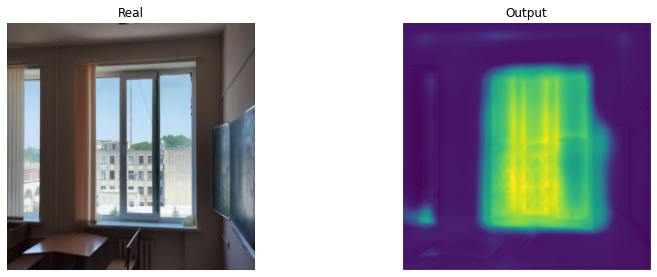

tensor(0.6891, device='cuda:0')

In [ ]:
predictor(unet_bce1,data_ts)

In [ ]:
# torch.save(unet_bce1,'/content/drive/MyDrive/Datashkola2/windows segment ez/unet_bce1.pt')

### Произвольные данные

In [ ]:
unet_bce = torch.load('/content/drive/MyDrive/Datashkola2/windows segment ez/unet_bce_dice.pt')

In [ ]:
# unet_bce = unet_bce.to('cpu')

In [ ]:
oleg = open('/content/drive/MyDrive/IMG_20220708_204542.jpg','rb').read()

In [ ]:
image = Image.open(io.BytesIO(oleg))

In [ ]:
npdata = np.array(image)

In [ ]:
npdata = np.rollaxis(npdata,2,0)

In [ ]:
npdata.shape

(3, 4000, 3000)

In [ ]:
size = (3,256, 256)
npdata = resize(npdata, size, mode='constant', anti_aliasing=True,) 

In [ ]:
npdata = torch.Tensor(npdata)
npdata = npdata[None,:,:,:]


In [ ]:
npdata.shape

torch.Size([1, 3, 256, 256])

In [ ]:
result = unet_bce.forward(npdata.to('cuda'))

In [ ]:
save_image(result,'/content/drive/MyDrive/Datashkola2/windows segment ez/oleg.jpg')


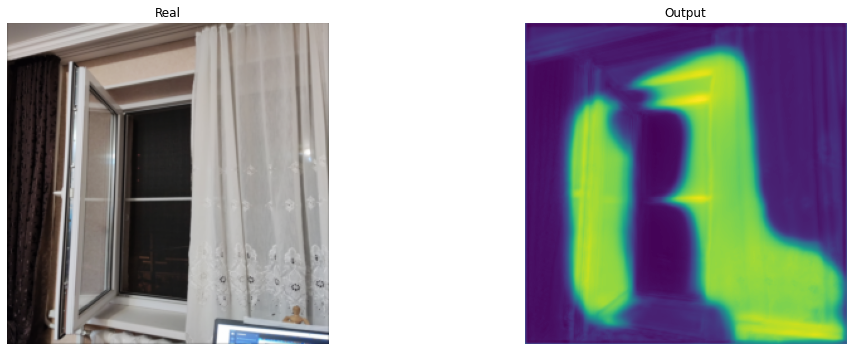

In [ ]:
plt.figure(figsize=(17, 13))

# вывод на экран результатов
plt.subplot(2, 2, 1) 
X_hat = npdata.to('cpu')
X_hat = X_hat.squeeze(0)
# print(type(X_hat),X_hat)
plt.imshow(np.rollaxis(X_hat.numpy(), 0, 3), cmap='gray')
plt.title('Real')
plt.axis('off')


plt.subplot(2, 2, 2) 
#print(type(X_hat))
Y_hat = result.detach().to('cpu')
Y_hat = Y_hat.squeeze(0)
# print(Y_hat.detach().numpy())
plt.imshow(Y_hat.numpy()[0])
plt.title('Output')
plt.axis('off')
plt.show()


